<a href="https://colab.research.google.com/github/SalmanRafiullah/EAI6000/blob/master/Assignment_3_Street_View_House_Numbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Street View House Numbers Dataset


The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 0, '9' has label 8 and '0' has label 9. Your goal is to build a model that recognizes the correct digit.

In [1]:
%matplotlib inline
!pip install openml # Uncomment to run in Google Colab

#Import helper libraries
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pickle
import time
from PIL import Image
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix


#Update tensor version
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#Impoprt keras libraries
from keras import utils
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras

     |████████████████████████████████| 163kB 2.7MB/s 
  Created wheel for openml: filename=openml-0.10.2-cp36-none-any.whl size=190318 sha256=57189a240ed5bfa8bf98713d4a0a976f6cb5adb75f8fb3e9bdf71695e0e423ef
  Stored in directory: /root/.cache/pip/wheels/71/ec/5f/aaad9e184680b0b8f1a02ff0ec640cace5adf5bff7bb0af1b4
  Created wheel for liac-arff: filename=liac_arff-2.4.0-cp36-none-any.whl size=13335 sha256=9631cd1bb62a9a5454f6dda3223f41d8bf2697290b67030ba964554900869690
  Stored in directory: /root/.cache/pip/wheels/d1/6a/e7/529dc54d76ecede4346164a09ae3168df358945612710f5203
Successfully built openml liac-arff
TensorFlow 2.x selected.


Using TensorFlow backend.


In [0]:
# Download Streetview data. Takes a while to download (5-10 min).
SVHN = oml.datasets.get_dataset(41081)
X, y, cats, attrs = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

In [0]:
# To save time, you can save the dataset to a Google drive, and load it quickly later
#from google.colab import drive
#drive.mount('/content/drive')

#with open("drive/My Drive/SVHN.pkl", "wb") as f:
#    pickle.dump(X, f, protocol=pickle.HIGHEST_PROTOCOL)
#    pickle.dump(y, f, protocol=pickle.HIGHEST_PROTOCOL)   
#    pickle.dump(cats, f, protocol=pickle.HIGHEST_PROTOCOL)
#    pickle.dump(attrs, f, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
#(Uncomment to) Load SVHN dataset from Google drive
#from google.colab import drive
#drive.mount('/content/drive')

#with open("drive/My Drive/SVHN.pkl", "rb") as f:
#    X = pickle.load(f)
#    y = pickle.load(f)
#    cats = pickle.load(f)
#    attrs = pickle.load(f)

## Data description

### Shape of image

What is the shape of the image data X? How many images are there? Explain why each image has 3072 values.

In [5]:
print(f'The shape of the image data X is {X.shape}')

The shape of the image data X is (99289, 3072)




> There are 99289 images with 3072 data points each. The 3072 point can be described as a matrix of 32x32x3. The image being 32x32 pixels explained in R,G and B colours as 3 seperate pixel values.



### Plot images

You can use the following function to plot the first 10 images to get a sense of the data.

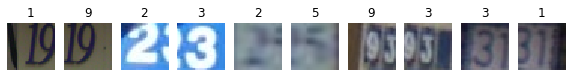

In [6]:
# Plots image. Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    if grayscale:
        [ax.imshow(X[n].reshape(32, 32)/255, cmap='gray')
         for n,ax in enumerate(axes)]
    else:
        [ax.imshow(X[n].reshape(32, 32, 3)/255) for n,ax in enumerate(axes)]
    [ax.set_title((y[n]+1)) for n,ax in enumerate(axes)]
    [ax.axis('off') for ax in axes]
plot_images(X[0:10], y[0:10]);

## Data processing

Next, we will convert the images to greyscale and normalize the data to fall within the range 0 to 1. Plot the first 10 images to verify that the conversion worked.

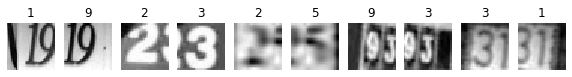

In [7]:
#Initialize variable X_grayscale to store grayscale images
X_grayscale = np.ndarray(shape=(len(X),32,32),dtype=float)
#Create a copy of the variable X as an int
X1 = X.astype('uint8')
for i in range(len(X)):
  image = Image.fromarray(X1[i].reshape(32,32,3))
  X_grayscale[i] = np.array(image.convert('L'))
plot_images(X_grayscale[0:10],y[0:10],grayscale=True);

In [0]:
#Scale the images and store labels as float
X_scaled = X_grayscale.reshape(len(X_grayscale),1024).astype('float32')/255
y_scaled = y.astype('float32')

## Evaluate different linear models

1. To save time, use a stratified 1% subsample of the data. Plot the distribution of the classes (as a histogram) for both the original data and the subsample to verify this was done correctly. (hint: a quick way to do it is to borrow the stratify option with sklearn.model_selection.train_test_split)
2. Evaluate k-Nearest Neighbors, Logistic Regression and Linear SVM on this sample, using their default hyperparameter settings. Use cross-validation with 3 folds, output the training accuracy and test accuracy (feel free to reuse code from past assignments). [Time](https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution) how long execution takes.
3. Discuss the results. Are they what you expected? Are the models over/underfitting? What should be done to improve the results?
4. Now evaluate the same models using 3% of the data. Discuss the results. Is the run time what you expect? Which models perform better or worse than the 1% training? How can you explain this in terms of underfitting/overfitting?

#### 1 Subsample of data

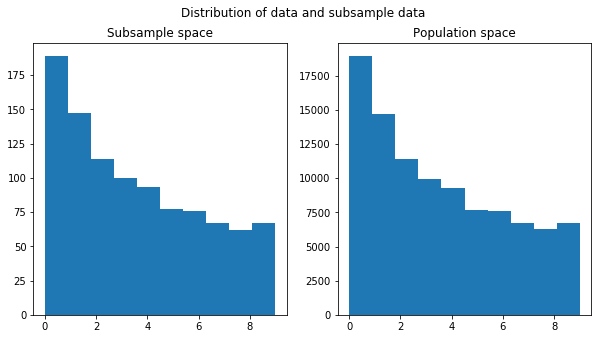

In [9]:
#Take a 1% subsample of the data
X_sub, _, y_sub, _ = train_test_split(X_scaled,y_scaled,test_size=0.99,stratify=y_scaled)

#Define the plotting area
fig, (ax,ay) = plt.subplots(1,2,figsize=(10,5))

#Define counts and bins for subsample data
counts, bins = np.histogram(y_sub)
#Plot histogram
ax.hist(bins[:-1], bins, weights=counts)
#Set title
ax.set_title('Subsample space')

#Define counts and bins for population data
counts1, bins1 = np.histogram(y_scaled)
#Plot histogram
ay.hist(bins1[:-1], bins1, weights=counts1)
#Set chart title
ay.set_title('Population space')

#Set image title
fig.suptitle('Distribution of data and subsample data')

#Show the plot
plt.show()

#### 2 Evaluation of Linear Models

In [0]:
#Define function to evaluate the models
def evaluate_learners(Classifier,X,y):
  train_score = []
  test_score = []
  time_score = []
  for item in range(len(Classifier)):
    start_t = time.time()
    a=cross_validate(Classifier[item],X,y,return_train_score=True,cv=3)
    test_score.append(a['test_score'].tolist())
    train_score.append(a['train_score'].tolist())
    time_score.append(time.time()-start_t)
  return train_score,test_score,time_score

In [11]:
#Define classifiers
classifiers = [LogisticRegression(),LinearSVC(),KNeighborsClassifier(n_jobs=-1)]
#Run evaluator function on all classifiers
train_scores, test_scores, time_scores = evaluate_learners(classifiers,X_sub,y_sub)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [12]:
#Define labels to be displayed for each classifier
Label = ['Logistic Regression','Linear SVM','k-Nearest Neighbours']

print('The time taken for each execution is:\n')

#Loop through each classifier
for i in range(len(classifiers)):
  #Print time taken
  print(f'%s : %ss' % (Label[i],np.round(time_scores[i],2)) )

print('\nThe train accuracy of classifiers is:\n')

#Print train accuracy
for i in range(len(classifiers)):
  print(f'%s : %s' % (Label[i],np.round(train_scores[i],2)) )

#Print test accuracy
print('\nThe test accuracy of classifiers is:\n')
for i in range(len(classifiers)):
  print(f'%s : %s' % (Label[i],np.round(test_scores[i],2)) )

The time taken for each execution is:

Logistic Regression : 1.32s
Linear SVM : 30.35s
k-Nearest Neighbours : 3.62s

The train accuracy of classifiers is:

Logistic Regression : [0.55 0.53 0.53]
Linear SVM : [0.78 0.79 0.79]
k-Nearest Neighbours : [0.47 0.47 0.47]

The test accuracy of classifiers is:

Logistic Regression : [0.17 0.15 0.21]
Linear SVM : [0.17 0.15 0.2 ]
k-Nearest Neighbours : [0.22 0.22 0.26]


#### 3 Results of evaluation



> 1. The train accuracy for each model is better than the test accuracy which means the model does not generalize well. This is as expected.
2. The models are all overfitting.
3. Regularization of loss can help in improving the models.



#### 4 Model evaluations for 3% data

In [0]:
#Create new subset of data with 3% of population data
X_sub1, _, y_sub1, _ = train_test_split(X_scaled,y_scaled,test_size=0.97,stratify=y_scaled)

In [14]:
#Run evaluator function on all classifiers
train_scores1, test_scores1, time_scores1 = evaluate_learners(classifiers,X_sub1,y_sub1)

#Print time, train and test accuracy
print('The time taken for each execution is:\n')

#Loop through and print time taken
for i in range(len(classifiers)):
  print(f'%s : %ss' % (Label[i],np.round(time_scores1[i],2)) )

#Loop through and print training accuracy
print('\nThe train accuracy of classifiers is:\n')
for i in range(len(classifiers)):
  print(f'%s : %s' % (Label[i],np.round(train_scores1[i],2)) )

#Loop through and print test accuracy
print('\nThe test accuracy of classifiers is:\n')
for i in range(len(classifiers)):
  print(f'%s : %s' % (Label[i],np.round(test_scores1[i],2)) )

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


The time taken for each execution is:

Logistic Regression : 2.74s
Linear SVM : 116.76s
k-Nearest Neighbours : 13.72s

The train accuracy of classifiers is:

Logistic Regression : [0.36 0.35 0.36]
Linear SVM : [0.55 0.57 0.54]
k-Nearest Neighbours : [0.52 0.54 0.54]

The test accuracy of classifiers is:

Logistic Regression : [0.21 0.19 0.2 ]
Linear SVM : [0.19 0.16 0.18]
k-Nearest Neighbours : [0.3  0.32 0.32]




> 1. The run time expected would be thrice the run time of 1% subsample data. Logistic regression takes lesser than the expected time while SVM and k-Nearest Neighbours take more than thrice the time.
2. The accuracy of Logistic Regression and Linear SVM decreases with increase in data while that of k-Nearest Neighbours increases with increase in data.
3. With increase in data the accuracy of k-Nearest Neighbours decreases suggesting that the model was underfitting on the previous data.



## Evaluate feed-forward neural network

Counter-intuitively, even though the linear models above are slow, you can easily train the small neural network below with 100% of the data in very little time. Learn more about Google Colab if you're curious: https://research.google.com/colaboratory/faq.html 
1. Train a neural network on the full (100%) data. Start with a single hidden layer with 256 neurons, and the same output layer as this week's Fashion-MNIST lab. Evaluate the accuracy using an 80/20 train test split. How does it compare with the linear models?
2. Plot the confusion matrix. Which digits are often confused with each other? 
3. Plot the first 15 correctly classified examples and the first 15 incorrectly classified examples, along with a bar plot of the predictions array. You can use the provided plotting functions. What sort of errors do you see? Are these indeed 'hard' examples that are easy to get wrong?


In [0]:
#Split the data in train and test as 80-20
X_train,X_test, y_train, y_test = train_test_split(X_scaled,y_scaled,test_size=0.2,stratify=y_scaled)

#### 1 Single hidden layer neural network

In [0]:
# Setting up model layers
#Define input layer
inputs = keras.Input(shape=(1024,), name='digits')
#Define the hidden layer
x = layers.Dense(256, activation='relu', name='dense_1')(inputs)
#Define output layer
outputs = layers.Dense(10, name='predictions')(x)

#Define the model
model = keras.Model(inputs=inputs, outputs=outputs)

In [0]:
# Compile the model
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

In [18]:
#Train model
print('# Fit model on training data')
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=20)
#Print loss and accuracy of each Epoch
print('\nhistory dict:', history.history)

# Fit model on training data
Train on 79431 samples
Epoch 1/20
79431/79431 [==============================] - 4s 53us/sample - loss: 2.1538 - sparse_categorical_accuracy: 0.2364
Epoch 2/20
79431/79431 [==============================] - 2s 27us/sample - loss: 1.6303 - sparse_categorical_accuracy: 0.4703
Epoch 3/20
79431/79431 [==============================] - 2s 26us/sample - loss: 1.3721 - sparse_categorical_accuracy: 0.5657
Epoch 4/20
79431/79431 [==============================] - 2s 26us/sample - loss: 1.2493 - sparse_categorical_accuracy: 0.6113
Epoch 5/20
79431/79431 [==============================] - 2s 27us/sample - loss: 1.1742 - sparse_categorical_accuracy: 0.6388
Epoch 6/20
79431/79431 [==============================] - 2s 26us/sample - loss: 1.1170 - sparse_categorical_accuracy: 0.6552
Epoch 7/20
79431/79431 [==============================] - 2s 26us/sample - loss: 1.0765 - sparse_categorical_accuracy: 0.6703
Epoch 8/20
79431/79431 [==============================] - 2s 26us/

In [19]:
print('# Accuracy of model on test dataset\n')
#Print accuracy of model on test data
results = model.evaluate(X_test,y_test,batch_size=128)
print(results)

# Accuracy of model on test dataset

19858/19858 [==============================] - 0s 23us/sample - loss: 1.0543 - sparse_categorical_accuracy: 0.6938
[1.054328182358578, 0.69382614]


In [0]:
#Make predictions
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
#Make class predictions
class_predictions = model.predict(X_test)
#Calculate the prediction probibilities for each class for each image
prediction_probabilities = probability_model.predict(X_test)
#Predict the class of test images
y_pred = np.argmax(class_predictions,axis=-1)





> Learning models have a significantly higher accuracy than linear models.





### 2 Confusion matrix

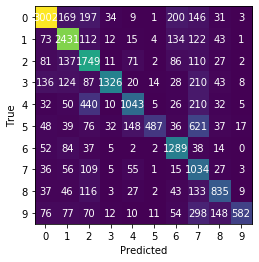

In [21]:
#Confusion matrix
cm = confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
for i in range(100):
    ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")



> Digits with similar strokes and similar shapes are most confused as others. The most misclassified class is 2, which is classified as a 4 which intuitively has similar storkes.



### 3 Plot of correctly and incorrectly classified samples

In [0]:
#Define function to plot image
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i].reshape(32,32)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
#
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label+1,
                                100*np.max(predictions_array),
                                true_label+1),
                                color=color)

#Define function to plot prediction probabilities
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks([1,2,3,4,5,6,7,8,9,0],rotation=90)
  plt.yticks([])
  thisplot = plt.bar([1,2,3,4,5,6,7,8,9,0], predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [0]:
# Take a subset of 25 misclassified values to display
misclassified_subset = np.where(y_pred.astype('int') != y_test.astype('int'))[0][:15]
# Take a subset of 25 correctly classified values to display
classified_subset = np.where(y_pred == y_test.astype('int'))[0][:15]

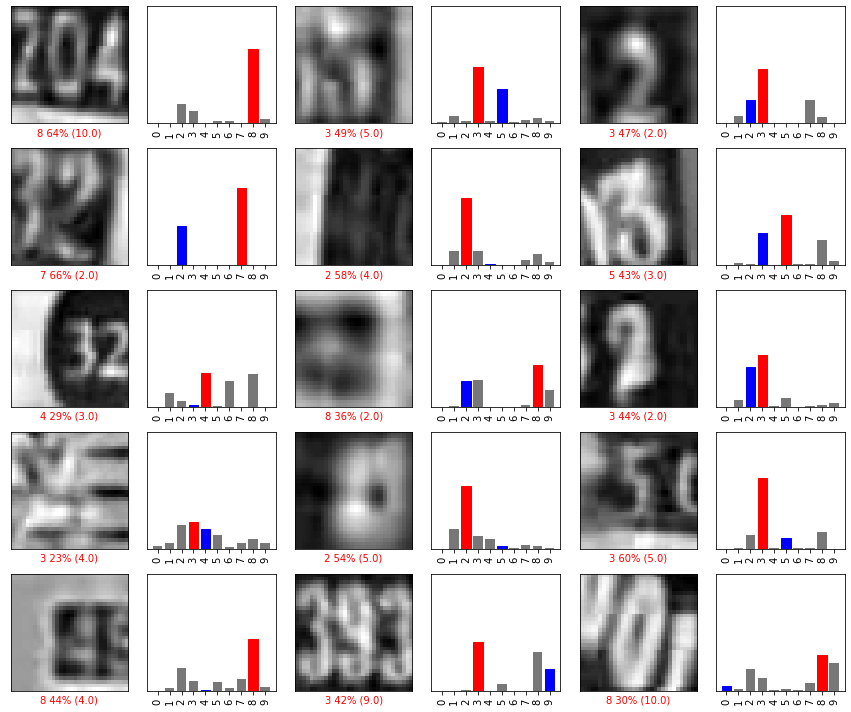

In [24]:
#Print misclassified images

#Define number of rows for plotting area
num_rows = 5
#Define number of columns for plotting area
num_cols = 3
#Specify number of images
num_images = num_rows*num_cols
#Define plotting area
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
#Loop and plot each image along side its probability function
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, prediction_probabilities[misclassified_subset[i]], y_test[misclassified_subset], X_test[misclassified_subset])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, prediction_probabilities[misclassified_subset[i]], y_test[misclassified_subset].astype('int'))
plt.tight_layout()
plt.show()

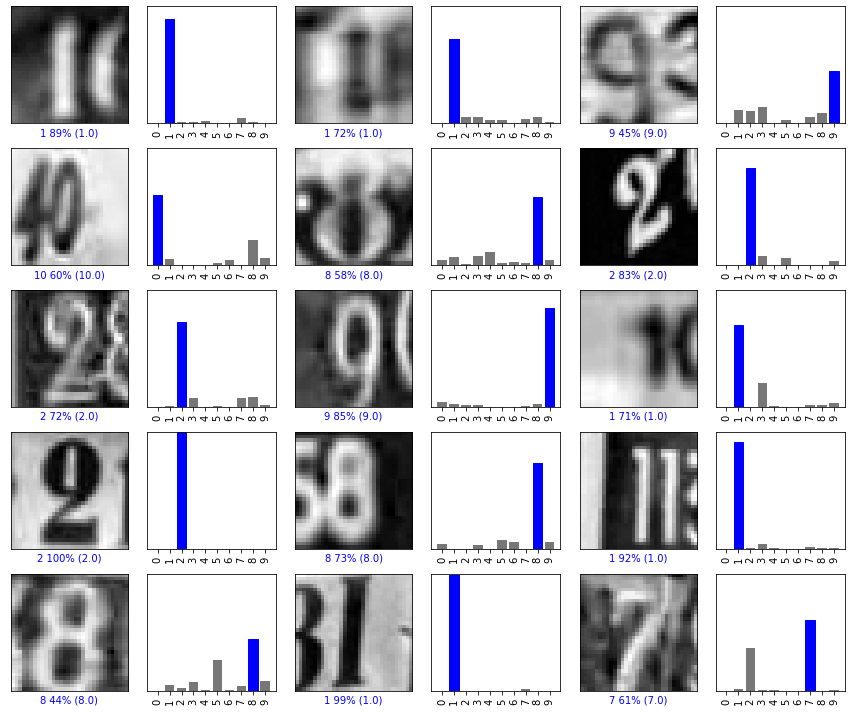

In [25]:
#Plot correctly classified images

#Define plot area
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
#Loop and plot each image along side its probability function
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, prediction_probabilities[classified_subset[i]], y_test[classified_subset], X_test[classified_subset])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, prediction_probabilities[classified_subset[i]], y_test[classified_subset].astype('int'))
plt.tight_layout()
plt.show()

> Errors are mostly due to blurred numbers making it harder for the algorithm to define a decision boundary. Not all misclassifications look like they are hard decisions indicating that there is scope for improvement in the model.

## Bonus question

Bonus challenge: 
Can you improve the model performance from this first Keras model?
If you wonder about how researchers get to 98% accuracy, here is a list of papers :)
https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#5356484e 

In [26]:
# Setting up model layers

#Setting the input layer
inputs = keras.Input(shape=(1024,), name='digits')
#Setting first hidden layer
x = layers.Dense(256, activation='elu', name='dense_1')(inputs)
#Specifying a dropout to avoid over fitting
x = layers.Dropout(0.1)(x)
#Setting the second hidden layer
x = layers.Dense(256, activation='elu', name='dense_2')(x)
#Specifying a dropout to avoid over fitting
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(10, name='predictions')(x)

#Define the model
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

#Train model
print('# Fit model on training data')
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=80)

# Fit model on training data
Train on 79431 samples
Epoch 1/80
79431/79431 [==============================] - 5s 64us/sample - loss: 1.9157 - sparse_categorical_accuracy: 0.3494
Epoch 2/80
79431/79431 [==============================] - 5s 59us/sample - loss: 1.3250 - sparse_categorical_accuracy: 0.5761
Epoch 3/80
79431/79431 [==============================] - 5s 59us/sample - loss: 1.1339 - sparse_categorical_accuracy: 0.6441
Epoch 4/80
79431/79431 [==============================] - 5s 58us/sample - loss: 1.0285 - sparse_categorical_accuracy: 0.6801
Epoch 5/80
79431/79431 [==============================] - 5s 59us/sample - loss: 0.9550 - sparse_categorical_accuracy: 0.7063
Epoch 6/80
79431/79431 [==============================] - 5s 66us/sample - loss: 0.8976 - sparse_categorical_accuracy: 0.7259
Epoch 7/80
79431/79431 [==============================] - 5s 59us/sample - loss: 0.8511 - sparse_categorical_accuracy: 0.7400
Epoch 8/80
79431/79431 [==============================] - 5s 58us/

In [27]:
#Print loss and accuracy of the model on training data
print('\nhistory dict:', history.history)
#Print test accuracy of model
print('# Accuracy of model on test dataset\n')
results = model.evaluate(X_test,y_test,batch_size=64)
print(results)


history dict: {'loss': [1.9157039169425896, 1.3250220375901718, 1.1338578038214677, 1.0285364656537752, 0.9549678696171234, 0.8976204000983999, 0.8510914712401786, 0.8197465144488292, 0.7913368110900256, 0.7714055814393478, 0.747158371323573, 0.7342390913336048, 0.7194919482152472, 0.7030643575375884, 0.6929232418950607, 0.6800618027818615, 0.6700115132224692, 0.6606803643831131, 0.6512741449901851, 0.6463270413524544, 0.6376508747632669, 0.6288432531953916, 0.6214250238810609, 0.6176638644534715, 0.6125068669856075, 0.6087663226165685, 0.5990330880011323, 0.5966643574984287, 0.5900848207231557, 0.5884222156313781, 0.5782212817496024, 0.5743248486389492, 0.5755309912019516, 0.5698632998221622, 0.5679609197359924, 0.565847286838891, 0.5601596290105445, 0.5561982029593219, 0.5533990113552193, 0.5513490527940309, 0.5462976332547866, 0.5393546874645837, 0.5428158132191085, 0.5429726545518435, 0.5374527144366934, 0.5367485828481662, 0.5309865952762731, 0.5281064925193967, 0.527401692571458



> The accuracy of the model has increased from 73.9% to 86% on training data and from 71.57% to 84% on test data.
The loss has reduced from 87.3% to 47% in training data and from 94% to 63.7% in test data.
There were 5645 misclassifications in the first model which have been reduced to 3171 in the improved model.

